## CME241 Assignment 2

###  Model the game of Snake and Ladders with FiniteMarkovProcess class.
What is the state space and structure of transition probability?

Using the standard board provided,I consider the whole board with position 0 to 99 as the possible state space. So the state space $S=\{1,....100\}$. Out of all the state, 1 is the starting state and 100 is the terminating state as if a player reaches 100, the game ends. The transition probability from $S_t$ to $S_t+1,S_t+2...,S_t+6$ is 1/6 without considering the ladders and snakes. The end probability might be different since the player cannot go beyond 100. With ladder or snake which will lead player from $a$ to $b$. All the transition probality from $c$ to $a$ is now the tranisition probability from $c$ to $b$ and the transition probability to $a$ will be zero.

In [87]:
from dataclasses import dataclass
from typing import Mapping, Dict
from rl.distribution import Categorical, Constant
from rl.markov_process import Transition, FiniteMarkovProcess,MarkovProcess
from scipy.stats import poisson
import numpy as np


In [88]:
@dataclass(frozen=True)
class SnakeState:
    position: int

In [89]:
## initiate a markov process
@dataclass
class SnakeMP(MarkovProcess[SnakeState]):
    def __init__(
        self,
        board_size: int,
        ladders
    ):
        self.board_size: int = board_size
        self.ladders=ladders
        self.transition_matrix=self.get_matrix()
        super().__init__()
    ##this function generate a transition matrix given the size of the board
    def get_matrix(self):
        mat=np.zeros((self.board_size,self.board_size))
        for i in range(self.board_size-1):
            for j in range(i+1,i+7):
                mat[i][min(j,self.board_size-1)]+=1/6
        for ladder in self.ladders:
            for i in range(board_size):
                for j in range(board_size):
                    if(j==ladder[0] and mat[i][j]>0):
                        mat[i][ladder[1]]+=mat[i][j]
                        mat[i][j]==0
        return mat
    def transition(self, state: SnakeState) -> Categorical[SnakeState]:
        if(state.position==self.board_size-1):
            return None
        
        state_probs_map: Mapping[SnakeState, float] = {
                SnakeState(i):self.transition_matrix[state.position][i]
                for i in range(self.board_size)
                }
        return Categorical(state_probs_map)
        

In [90]:
## Snake Finite inheritates from FiniteMarkovProcess class
class SnakeFinite(FiniteMarkovProcess[SnakeState]):
    def __init__(
        self,
        board_size: int,
        ladders
    ):
        self.markov=SnakeMP(board_size,ladders)
        super().__init__(self.get_transition_map())
    def get_transition_map(self) -> Transition[SnakeState]:
        d: Dict[SnakeState, Categorical[SnakeState]] = {}
        for alpha in range(self.markov.board_size):
            d[SnakeState(alpha)]=self.markov.transition(SnakeState(alpha))
        ## position 99 is considered as the terminal state
        return d

Create a sample board and run simulation of 10000 times and plot out the number of round needed to finish the game.

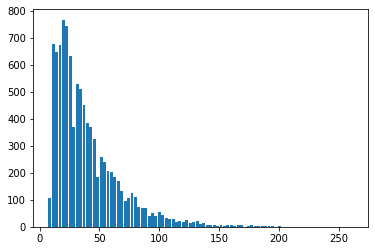

In [91]:
import matplotlib.pyplot as plt
if __name__ == '__main__':
    board_size=100
    ladder=np.array([[2,38],[6,47],[11,50],[19,40],[24,56],[27,34],[30,5],
                     [37,0],[44,73],[48,7],[52,16],[59,84],[64,13],[66,89],
                     [68,91],[69,33],[75,36],[76,82],[81,62],[87,49],[93,41],
                     [97,53]])
    snake_mp = SnakeFinite(board_size=board_size,ladders=ladder
    )
    simulation=10000
    counts=[]
    round=0
    for i in snake_mp.traces(Constant(SnakeState(0))):
            count=0
            for j in i:
                count+=1
            counts.append(count)
            round+=1
            if round>=simulation:
                break
    plt.hist(x=counts, bins='auto',rwidth=0.85)

In [92]:
np.mean(counts)

39.6073

#### Model the snake and ladder with FiniteMarkovRewardProcess class.

The model should use 1 as the reward for each transition as each transition symbolize a dice roll and we want to sum up all the rewards at the end.

In [93]:
from rl.markov_process import FiniteMarkovRewardProcess
from rl.markov_process import RewardTransition
class SnakeReward(FiniteMarkovRewardProcess[SnakeState]):
    def __init__(
        self,
        board_size: int,
        ladders
    ):
        self.finiteMP=SnakeFinite(board_size,ladder)
        self.board_size: int = board_size
        super().__init__(self.get_transition_reward_map())
        ##this function generate a transition matrix given the size of the board
    def get_transition_reward_map(self) -> RewardTransition[SnakeState]:
        d: Dict[SnakeState, Categorical[Tuple[SnakeState, float]]] = {}
        for alpha in range(self.board_size-1):
            state = SnakeState(alpha)
            state_probs_map: Mapping[Tuple[SnakeState, float],float] = {
                (k,1):v for k,v in self.finiteMP.markov.transition(state).table().items()
                }
            d[state] = Categorical(state_probs_map)
        d[SnakeState(self.board_size-1)]=None
        return d
        

Get the expected value of the number of rolls

In [94]:
board_size=100
ladder=np.array([[2,38],[6,47],[11,50],[19,40],[24,56],[27,34],[30,5],
                     [37,0],[44,73],[48,7],[52,16],[59,84],[64,13],[66,89],
                     [68,91],[69,33],[75,36],[76,82],[81,62],[87,49],[93,41],
                     [97,53]])
snake_mrp = SnakeReward(board_size=board_size,ladders=ladder)
snake_mrp.get_value_function_vec(gamma = 1)[0]

38.97823849196711

### Frog game

Given a frog and a distance x, a frog can jump 1 to x steps and calculate the expected number of jumps.

We want to model it as a finite reward Markov process with the reward for each jump to be 1 and the total reward of the whole process is the number of jumps.

In [95]:
@dataclass(frozen=True)
class FrogState:
    position: int

In [96]:
class FrogReward(FiniteMarkovRewardProcess[FrogState]):
    def __init__(
        self,
        dist: int,
    ):
        self.dist: int = dist
        self.transition_matrix=self.get_matrix()
        super().__init__(self.get_transition_reward_map())
        ##this function generate a transition matrix given the size of the board
    def get_matrix(self):
        mat=np.zeros((self.dist,self.dist))
        for i in range(self.dist):
            for j in range(i+1,self.dist):
                mat[i][min(j,self.dist-1)]+=1/(self.dist-i-1)
        return mat
    def get_transition_reward_map(self) -> RewardTransition[FrogState]:
        d: Dict[FrogState, Categorical[Tuple[FrogState, float]]] = {}
        for alpha in range(self.dist-1):
            state = FrogState(alpha)
            state_probs_map: Mapping[FrogState, float] = {
                (FrogState(i),1):self.transition_matrix[alpha][i]
                for i in range(self.dist)
                }
            d[state] = Categorical(state_probs_map)
        d[FrogState(self.dist-1)]=None
        return d

We test out with the distance of 10.

In [97]:
frog_mrp=FrogReward(10)
rewards=[]
for i in frog_mrp.reward_traces(Constant(FrogState(0))):
    reward=0
    for j in i:
        reward+=j.reward
    rewards.append(reward)
    if(len(rewards)>=10000):
        break

In [98]:
frog_mrp.get_value_function_vec(gamma = 1)[0]

2.828968253968254

### Extend the Stock price example from Chapter 1 to be markov reward with custom reward function

We need to model the stock price with the MarkovRewardProcess class and we need to leave the reward function as an input for the model.

In [99]:
from rl.markov_process import MarkovRewardProcess
from rl.distribution import SampledDistribution
from typing import Tuple, Dict
from rl.gen_utils.common_funcs import get_logistic_func
@dataclass(frozen=True)
class StockState:
    price: int
class StockMRP1(MarkovRewardProcess[StockState]):
    def __init__(
        self,
        rewardf,
        level_param: int,
        alpha1: float
    ):
        self.level_param=level_param  # level to which price mean-reverts
        self.alpha1= alpha1  # strength of mean-reversion (non-negative value)
        self.rewardf=rewardf
    def up_prob(self, state: StockState) -> float:
        return get_logistic_func(self.alpha1)(self.level_param - state.price)
    def transition_reward(
        self,
        state: StockState
    ) -> SampledDistribution[Tuple[StockState, float]]:

        def sample_next_state_reward(state=state) ->\
                Tuple[StockState, float]:
            next_state=StockState(state.price+np.random.choice([-1,1],1,p=[1-self.up_prob(state),self.up_prob(state)])[0])
            reward: float =self.rewardf(state)
            return next_state, reward

        return SampledDistribution(sample_next_state_reward)

In [100]:
def f(state:StockState):
    return state.price-10
stock_mrp=StockMRP1(f,10,0.25)
gamma=0.5

In [101]:
rewards=[]
for i in stock_mrp.reward_traces(Constant(StockState(10))):
    trace=[0]
    reward=0
    count=0
    for j in i:
        reward+=j.reward*gamma
        trace.append(reward)
        count+=1
        if(count>=20):
            break
    rewards.append(trace)
    if(len(rewards)>=30):
        break

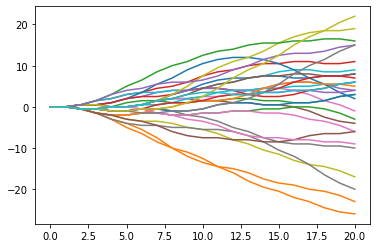

In [102]:
for trace in rewards:
    plt.plot(trace)